# **Collecting weather data from an API**
**Name**: Corpuz, Micki Laurren B.

**Section**: CPE22S3

**Instructor**: Engr. Roman Richard

**About the data**
> In this notebook, we will be collecting daily weather data from the National Centers for Environmental Information (NCEI) API. We will use the Global Historical Climatology
Network - Daily (GHCND) data set; see the documentation here.
Note: The NCEI is part of the National Oceanic and Atmospheric Administration (NOAA) and, as you can see from the URL for the API, this resource was created when the
NCEI was called the NCDC. Should the URL for this resource change in the future, you can search for the NCEI weather API to find the updated one.

**Using the NCEI API**
> Paste your token below

In [1]:
import requests

def make_request(endpoint, payload=None):
  """
  Make a request to a specific endpoint on the weather API
  passing headers and optional payload.

  Parameters:
  - endpoint: The endpoint of the API you want to
  make a GET request to.
  - payload: A dictionary of data to pass along
  with the request.

  Returns:
  Response object.
  """

  return requests.get(
      f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
      headers={
          'token': 'XkaqeIEyRpEAvMXJvbNofZPfAiqjsBDl'
      },
      params=payload
  )

**Collect All Data Points for 2018 In NYC (Various Stations)**
> We can make a loop to query for all the data points one day at a time. Here we create a list of all the results:

In [2]:
import datetime

from IPython import display # for updating the cell dynamically

current = datetime.date(2018, 1, 1)
end = datetime.date(2019, 1, 1)

results = []

while current < end:
  # update the cell with status information
  display.clear_output(wait=True)
  display.display(f'Gathering data for {str(current)}')

  response = make_request(
      'data',
      {
          'datasetid' : 'GHCND', # Global HIstorical Climatology Network - Daily (GHCND) dataset
          'locationid' : 'CITY:US360019', # NYC
          'startdate' : current,
          'enddate' : current,
          'units' : 'metric',
          'limit' : 1000 # max allowed
      }
  )

  if response.ok:
    # we extend the list instead of appeanding to avoid getting a nested list
    results.extend(response.json()['results'])

  # update the current date to avoid an infinite loop
  current += datetime.timedelta(days=1)

'Gathering data for 2018-12-31'

> Now, we can create a dataframe with all this data. Notice there are multiple stations with values for each datatype on a given day. We don't know what the stations are, but we
can look them up and add them to the data:

In [4]:
import pandas as pd

df = pd.DataFrame(results)
df.head()

,date,datatype,station,attributes,value
0,2018-01-01T00:00:00,PRCP,GHCND:US1CTFR0039,",,N,0800",0.0
1,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0015,",,N,1050",0.0
2,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0015,",,N,1050",0.0
3,2018-01-01T00:00:00,PRCP,GHCND:US1NJBG0017,",,N,0920",0.0
4,2018-01-01T00:00:00,SNOW,GHCND:US1NJBG0017,",,N,0920",0.0


> Save this data to a file:

In [5]:
df.to_csv('nyc_weather_2018.csv', index=False)

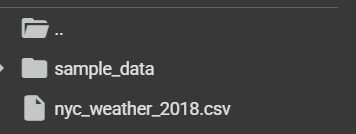

> and write it to the database:

In [6]:
import sqlite3

with sqlite3.connect('weather.db') as connection:
  df.to_sql(
      'weather', connection, index=False, if_exists='replace'
  )

> For learning about merging dataframes, we will also get the data mapping station IDs to information about the station:

In [7]:
response = make_request(
    'stations',
    {
        'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
        'locationid' : 'CITY:US360019', # NYC
        'limit' : 1000 # max allowed
    }
)

stations = pd.DataFrame(response.json()['results'])[['id', 'name', 'latitude', 'longitude', 'elevation']]
stations.to_csv('weather_stations.csv', index=False)

with sqlite3.connect('weather.db') as connection:
  stations.to_sql(
      'stations', connection, index=False, if_exists='replace'
  )

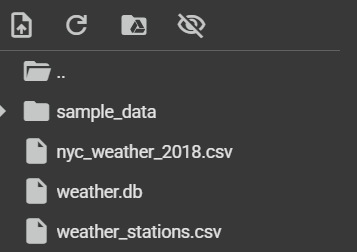